# Objectius de la Pràctica

Els diferents objectius d'aquesta pràctica és que us comenceu a familiaritzar amb casos de classificació (tant binaria com multiclass). Per aquest motiu respecte a la pràctica haureu d'entendre:

1. Generar un model de regressió Logística i entendre els diferents paràmetres que hi han i per a que serveixen
2. Entendre com regularitzar el overfitting i el underfitting del model (entendre errors de variance, bias...)
3. Entendre com cercar i evaluar el millor model 
4. Estratègies de validació i entrenament multiclass (Ovo, Ovr)

## Introducció

Per implementar una regressió logística, necessito una funció d'hipòtesi $h_{\theta}(x)$
, una funció de cost $J(\theta)$ , i una funció de degradat que calcula les derivades parcials de $J(\theta)$.

En regressió logística,$h_{\theta}(x)$ és la funció sigmoide. La funció sigmoide està fitada entre 0 i 1, i produeix un valor que es pot interpretar com una probabilitat. Aquest valor també pot ser una resposta sí / no amb un creuament, o un límit de decisió, a 0,5:

$$
h_{\theta}(x) = \frac{1}{1+e^{\theta_x}}
$$


L'ús del MSE de la regressió lineal no és una bona idea aquí, ja que la funció de cost resultant no és convexa i, per tant, no és adequada per al descens de gradient. En canvi, la diferència de $h_{\theta}(x^i)-y^i$ es calcula de manera diferent per y=0 & y=1 i el resultat es transforma logarítmicament en una funció convexa:

$$
J(\theta) = \frac{1}{m} \cdot \sum_{i=1}^m y^i log(h_{\theta}(x^i)) + (1-y^i)log(1-h_{\theta}(x^i))
$$

tot i així la derivada es comporta de manera idèntica només que la funció de cost es diferent.

Anem a veure un exemple més visual de com es comporta el regressor

(-2.5529898158340787, 2.2697546239876076)

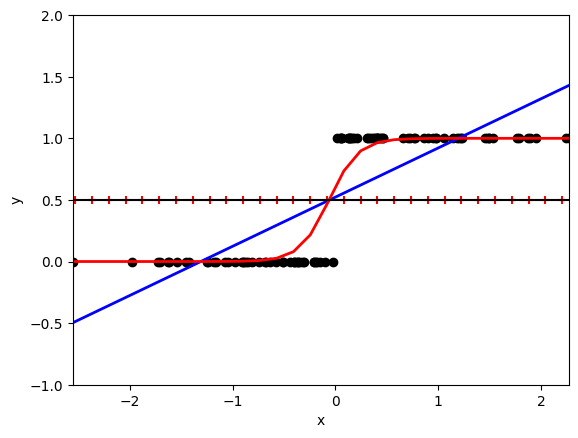

In [5]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

#definim la funció de la sigmoide
logistic = lambda s: 1.0 / (1.0 + np.exp(-s))

xmin, xmax = -10, 10
np.random.seed(0)
d = 0
X = np.random.normal(size = 100) + d
xmin, xmax = X.min(), X.max()

y = (X > d).astype(float) 
X = X[:, np.newaxis] 
X_test = np.linspace(-4, 4, 50)

# Linear Regression:
rgr = linear_model.SGDRegressor(loss='squared_error', learning_rate='constant', eta0=0.01)
rgr.fit(X, y)
plt.plot(X_test, rgr.coef_.ravel() * X_test + rgr.intercept_, color = 'blue', linewidth = 2)

# Logistic Regression:
clf = linear_model.SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.05, max_iter=1000000)
clf.fit(X, y)
loss = logistic(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color = 'red', linewidth = 2)


plt.axhline(0.5, color = 'black')
plt.scatter(X, y, color = 'black')
plt.scatter(X_test, X_test*0+0.5, color = 'red', marker='+')

plt.ylabel('y')
plt.xlabel('x')

plt.ylim(-1, 2)
plt.xlim(xmin, xmax)

### Dataset per treballar aquesta pràctica:

In [21]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()


# Visualitzarem només 3 decimals per mostra, i definim el num de files i columnes a mostrar
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('winequalityN.csv')
dataset = dataset.dropna()
dataset['is_red_wine'] = (dataset["type"] == 'red').astype(int)


print("Dimensionalitat de la BBDD:", dataset.shape)

Dimensionalitat de la BBDD: (6463, 14)


In [22]:
display(dataset)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red_wine
0,white,7.000,0.270,0.360,20.700,0.045,45.000,170.000,1.001,3.000,0.450,8.800,6,0
1,white,6.300,0.300,0.340,1.600,0.049,14.000,132.000,0.994,3.300,0.490,9.500,6,0
2,white,8.100,0.280,0.400,6.900,0.050,30.000,97.000,0.995,3.260,0.440,10.100,6,0
3,white,7.200,0.230,0.320,8.500,0.058,47.000,186.000,0.996,3.190,0.400,9.900,6,0
4,white,7.200,0.230,0.320,8.500,0.058,47.000,186.000,0.996,3.190,0.400,9.900,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,red,6.800,0.620,0.080,1.900,0.068,28.000,38.000,0.997,3.420,0.820,9.500,6,1
6492,red,6.200,0.600,0.080,2.000,0.090,32.000,44.000,0.995,3.450,0.580,10.500,5,1
6494,red,6.300,0.510,0.130,2.300,0.076,29.000,40.000,0.996,3.420,0.750,11.000,6,1
6495,red,5.900,0.645,0.120,2.000,0.075,32.000,44.000,0.995,3.570,0.710,10.200,5,1


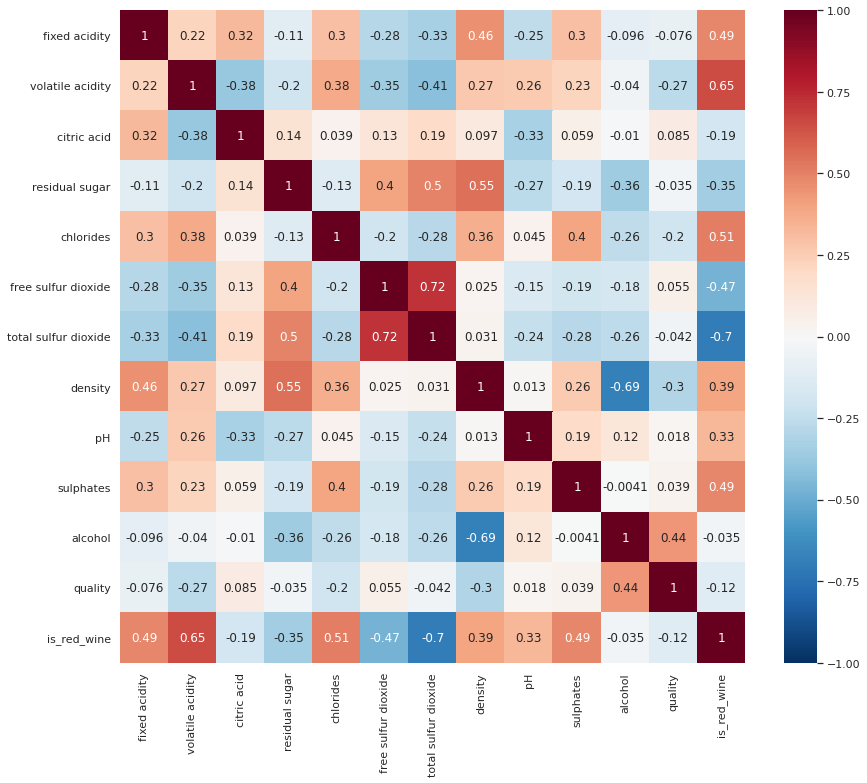

In [23]:
correlation = dataset.corr()
#display(correlation)
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

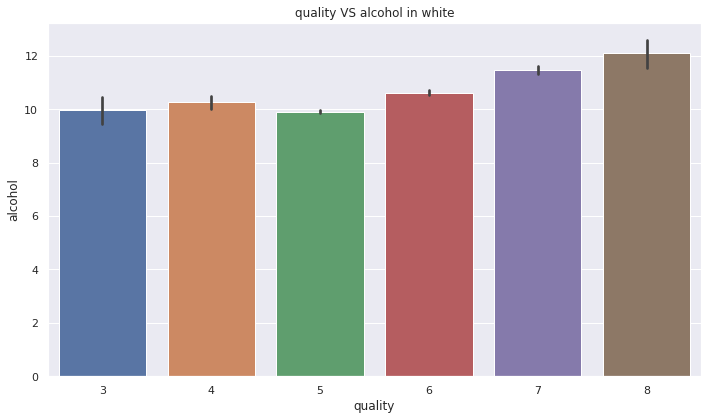

<Figure size 432x288 with 0 Axes>

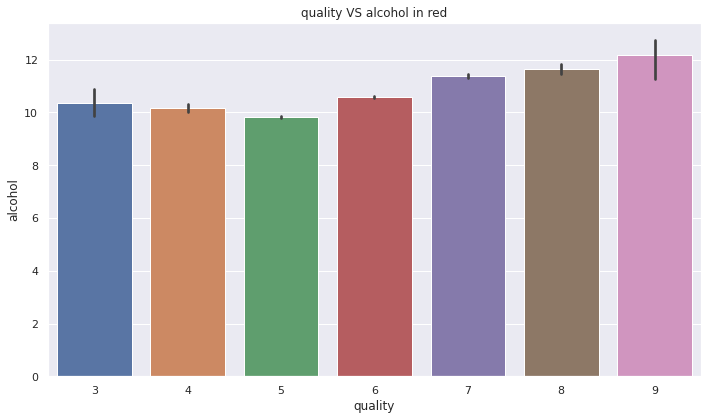

<Figure size 432x288 with 0 Axes>

In [24]:
fig, axs = plt.subplots(ncols=1,figsize=(10,6))
sns.barplot(x='quality', y='alcohol', data=dataset[dataset.type=="red"], ax=axs)
plt.title('quality VS alcohol in white')

plt.tight_layout()
plt.show()
plt.gcf().clear()

fig, axs = plt.subplots(ncols=1,figsize=(10,6))
sns.barplot(x='quality', y='alcohol', data=dataset[dataset.type=="white"], ax=axs)
plt.title('quality VS alcohol in red')

plt.tight_layout()
plt.show()
plt.gcf().clear()

Abans de començar amb els exercicis, preparem les dades per a que sigui una classificació binaria

In [29]:
#Defining the splits for categories. 1-5 will be poor quality, 6-10 will be great
bins = [1,5,10]

#0 for low quality, 1 for great quality
quality_labels=[0,1]
dataset['quality_categorical'] = pd.cut(dataset['quality'], bins=bins, labels=quality_labels, include_lowest=True)
# Split the data into features and target label
quality_raw = dataset['quality_categorical']
features_raw = dataset.drop(['type', 'quality', 'quality_categorical'], axis = 1)

In [26]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_raw, 
                                                    quality_raw, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples. {:.1f}% is positive".format(X_train.shape[0], 100*sum(y_train)/y_train.shape[0]))
print("Testing set has {} samples. {:.1f}% is positive".format(X_test.shape[0], 100*sum(y_test)/y_test.shape[0]))

display(X_test)

Training set has 5170 samples. 63.1% is positive
Testing set has 1293 samples. 64.3% is positive


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,is_red_wine
3859,7.300,0.250,0.260,7.200,0.048,52.000,207.000,0.996,3.120,0.370,9.200,0
4675,5.700,0.210,0.370,4.500,0.040,58.000,140.000,0.993,3.290,0.620,10.600,0
513,7.400,0.360,0.330,1.400,0.025,27.000,55.000,0.992,3.210,0.330,11.200,0
5490,9.000,0.450,0.490,2.600,0.084,21.000,75.000,0.999,3.350,0.570,9.700,1
4329,6.400,0.230,0.260,8.100,0.054,47.000,181.000,0.995,3.120,0.490,9.400,0
...,...,...,...,...,...,...,...,...,...,...,...,...
410,7.200,0.250,0.390,18.950,0.038,42.000,155.000,1.000,2.970,0.470,9.000,0
4562,5.600,0.180,0.300,10.200,0.028,28.000,131.000,0.995,3.490,0.420,10.800,0
5626,6.400,0.570,0.020,1.800,0.067,4.000,11.000,0.997,3.460,0.680,9.500,1
1248,7.200,0.180,0.310,1.100,0.045,20.000,73.000,0.993,3.320,0.400,10.800,0


## Logistic Regression 

En aquesta secció us demanem que apliqueu de sklearn el model de [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html):

Si feu proves amb diferents parametres, guardeu els resultats que obtingueu en una taula de pandas i els mostreu.

* Guarda resultats de temps, de precisió, de accuracy, tant de train com de test

cal veure l'efecte de 
* canviar el *learning rate*,
* el tamany del conjunt d'entrenament
* normalitzar les dades


TODO1 un cop feta aquesta funció per evaluar el model de Regressió Logística fés un anàlisi dels següents paràmetres i fes un estudi de com actuen i per què.

    penalty -->
    tol -->
    C --> 
    random_state (per què serveix?) -->
    solver --> 
    
    
TODO2 De totes les combinacions que creguis que són les adequades per encarar la classificació amb les dades que decideixis, digues quin és el millor model que has pogut aconseguir sota el teu criteri (Utilitza les mètriques que vegis convenients)(recorda tenir en compte alguns dels paràmetres d'adalt.(tingeus en compte també el lr)

!Nota: Investiga aquest link: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

TODO3 Un cop fet l'anàlisi fes un plot de com es comporten els coeficients si afegeixes una penalització l1 o l2 amb diferents valors de C i dona una explicació del que creus que està passant.

In [13]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score


def entrena_prediu_evalua(model, X_train, y_train, X_test, y_test, sample_size=1): 
    '''
    inputs:
       - model: el objecte que s'entrenarà
       - sample_size: el número de mostres del training set que es farán servir (en %)
       - X_train: caracteristiques entrenament
       - y_train: etiqueta entrenament
       - X_test: caracteristiques test
       - y_test: etiqueta test
    '''
    
    results = {}

    """
    Entrenar el model tenint en compte el 'sample_size'  [:len(y_train)*sample_size]
    """

    
    """
    Obtenir les prediccions del model sobre el conjunt d'entrenament i sobre el conjunt de test
    """
    
    """
    Calcular el accuracy i el F1-score del train i del test
    """
    results['temps'] = None
    results['accuracy_training'] = None 
    results['f1_training'] = None
    results['accuracy_test'] = None
    results['f1_test'] = None

    print("{} s'ha entrenat amb el {}% de mostres.".format(model.__class__.__name__, ))
    
    
    return results


## Multinomial 


Normalment entrenem un model d'aprenentatge automàtic per produir un sol valor o una única etiqueta com a sortida. Però quan el nombre de classes de sortida és més gran que 1, aquest és un problema de classificació multiclasse (pot passar que un problema sigui classificació multilabel, però ho veurem més endavant). Un-vs-all i un-vs-one són els dos principals enfocaments d'aprenentatge automàtic per resoldre un problema de classificació multiclasse

### One-Vs-Rest 

One-vs-rest (OvR  or One-vs-All/OvA) és un mètode heurístic per utilitzar algorismes de classificació binària per a la classificació multiclasse.

Es tracta de dividir el conjunt de dades multiclasse en múltiples problemes de classificació binària. Un classificador binari és llavors entrenat en cada problema de classificació binària i les prediccions es fan utilitzant el model amb una probabilitat més alta (arg max pel tipus de classe que és).

$$
argmax\{y_1, y_2, \cdots y_n\} | n \in \mathbb{R}
$$

### One-Vs-One

OVO divideix un conjunt de dades de classificació multiclasse en problemes de classificació binaris. A diferència de OVR que el divideix en un conjunt de dades binari per a cada classe, l'enfocament del OVO és dividir el conjunt de dades respecte a un problema de classificació binaria de tots contra tots. Per tant tenim 
$$
\frac{n * (n-1 )}{2}
$$
on n $=$ nombre de classes

Per exemple, considereu un problema de classificació multiclasse amb quatre classes: $vermell, blau, verd$ i $groc$. Això es podria dividir en sis conjunts de dades de classificació binaria:

    Binary Classification Problem 1: red vs. blue
    Binary Classification Problem 2: red vs. green
    Binary Classification Problem 3: red vs. yellow
    Binary Classification Problem 4: blue vs. green
    Binary Classification Problem 5: blue vs. yellow
    Binary Classification Problem 6: green vs. yellow
    
Tenint així 6 classificadors la sortida del final del model és 
$$
max\{{\sum_{i=1}^6 argmax[Model_i = C]}\}
$$

## Aquí tenim uns exemples molt naive per fer unes primeres proves

In [19]:
### OVR
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# define model
model = LogisticRegression(multi_class='ovr')
# fit model
model.fit(X, y)
# make predictions
yhat = model.predict(X)

print(yhat[:10])

[1 0 1 2 0 2 1 2 0 1]


In [20]:
### OVO
# define model
model = LogisticRegression()
# define ovo strategy
ovo = OneVsOneClassifier(model)
# fit model
ovo.fit(X, y)
# make predictions
yhat = ovo.predict(X)
print(yhat[:10])

[1 2 1 2 0 2 1 2 0 1]


TODO1 Com a primera prova de concepte investiga quina és la sortida dels models darrera la classificació final. Realment quina forma té la sortida del OVR, és un conjunt de probabilitats? i en el OVO?

TODO2 Juga amb el make_classification per veure en quins cassos és millor el OVR i en quins el OVO, fes una taula comparativa amb diferents combinacions i treu ses teves conclusions.

TODO3 Agafa el millor model que has pogut entrenar abans i tornat al executar canviant la estratègia de classificació tenint en compte que cada qualitat és una classe. Prova les dues estratègies i torna a treure conclusions sobre quins és el millor model que pots aconseguir. Quina estratègia fa servir el Logistic Regression per defecte? Has aconseguit millors resultats?

## Bias and Variance

Per cert, recordeu el què significa el error de Variança i el de bias.

<img src="bias_variance.png" width=600 height=600 />


Sempre que parlem de la predicció del model, és important entendre els errors de predicció (bias i variància). Hi ha un equilibri entre la capacitat d'un model per minimitzar el biaix i la variància. La comprensió adequada d'aquests errors ens ajuda no sols a construir models més precisos, sinó també a evitar l'overfitting i el underfitteing.

## Bias

El bias és la diferència entre la predicció mitjana del nostre model i el valor correcte que estem intentant predir. El model amb un gran bias presta molt poca atenció a les dades d'entrenament i simplifica massa el model. Sempre provoca un gran error en train i test. (underfitting

## Variance


Variance és la variabilitat de la predicció del model per a un punt de dades donat. Un model amb gran variància presta molta atenció a les dades d'entrenament i no es generalitza sobre les dades de test. Com a resultat, aquests models funcionen molt bé en les dades d'entrenament, però tenen altes taxes d'error en les dades de prova, resultant, així,  l'overfitting

**Tots els TODOS d'aquí són conceptuals. Agafa els millors models que has trobat per al apartat 1 i el 2 i realitza aquests canvis per a respondre les preguntes següents.**

* TODO 1 -> Què hem de fer per veure que els models que estem provant tenen un error de bias molt alt? (es a dir, models simples)

* TODO 2 -> Què passa si fem servir poques dades per entrenar (utilitza el paràmetre samples de la funció anterior)? (mostra com varien els resultats segons % de entrenament)

* TODO 3 -> I si utilitzem poques iteracions limitant el *max_iter*

* TODO 4 -> Què hem de fer per veure que el model que estem provant té un error de variança molt alt? (es a dir, model massa complexe)

* TODO 5 -> Crea models de features més complexes amb [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

* TODO 6 -> Podem reduir el error de variança si enlloc de classificar el vi blanc i el negre, els separessim?

* TODO 7 -> Sabrieu explicar-me aquesta [gráfica](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)? Podeu generar-la amb aquestes dades de entrenament?

